In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import requests
import json
import random
import pandas as pd
import datetime as dt
import numpy as np
import seaborn as sns
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from pandas import DataFrame, Series
from patsy import dmatrices
from scipy import stats
from sklearn import metrics
from sklearn.metrics import (precision_score, recall_score, f1_score, 
                             confusion_matrix, ConfusionMatrixDisplay, 
                             average_precision_score, balanced_accuracy_score, 
                             matthews_corrcoef, roc_auc_score)
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance



In [4]:
percentages_url = 'https://api.nhle.com/stats/rest/en/skater/percentages?limit=-1&cayenneExp=seasonId=20232024'
percentages_resp = requests.get(percentages_url)
percentages_json = percentages_resp.json()

In [5]:
df_percentages = DataFrame(percentages_json['data'])
df_percentages_filtered = df_percentages.loc[(df_percentages['positionCode'] != 'D') & (df_percentages['gamesPlayed'] >= 20)]
df_percentages_filtered = df_percentages_filtered.reset_index(drop=True)
df_percentages_filtered.drop(['skaterSavePct5v5', 'seasonId','shootingPct5v5', 'timeOnIcePerGame5v5', 'zoneStartPct5v5', 'satPercentage', 'satPercentageBehind', 'satPercentageAhead', 'satRelative', 'skaterShootingPlusSavePct5v5', 'usatPercentage', 'usatPercentageAhead', 'usatPercentageBehind', 'usatRelative'], axis=1, inplace=True)
df_percentages_filtered = df_percentages_filtered[['playerId', 'skaterFullName', 'lastName', 'positionCode', 'teamAbbrevs', 'gamesPlayed', 'shootsCatches','satPercentageClose',
 'satPercentageTied','usatPercentageTied', 'usatPrecentageClose']]

In [6]:
df_percentages_filtered

,playerId,skaterFullName,lastName,positionCode,teamAbbrevs,gamesPlayed,shootsCatches,satPercentageClose,satPercentageTied,usatPercentageTied,usatPrecentageClose
0,8478028,Fredrik Olofsson,Olofsson,L,COL,57,L,0.464,0.436,0.401,0.436
1,8475763,Kevin Hayes,Hayes,R,STL,79,L,0.450,0.443,0.430,0.436
2,8471698,T.J. Oshie,Oshie,R,WSH,56,R,0.433,0.416,0.411,0.431
3,8482259,Bobby McMann,McMann,C,TOR,56,L,0.523,0.518,0.509,0.530
4,8480748,Kiefer Sherwood,Sherwood,L,NSH,74,R,0.520,0.535,0.534,0.522
...,...,...,...,...,...,...,...,...,...,...,...
469,8474870,Tyler Johnson,Johnson,C,CHI,67,R,0.374,0.373,0.377,0.368
470,8475913,Mark Stone,Stone,R,VGK,63,R,0.455,0.431,0.421,0.453
471,8478831,Kevin Stenlund,Stenlund,C,FLA,105,R,0.488,0.511,0.488,0.475
472,8476483,Rickard Rakell,Rakell,R,PIT,70,R,0.527,0.528,0.525,0.516


In [7]:
summary_url = 'https://api.nhle.com/stats/rest/en/skater/summary?limit=-1&cayenneExp=seasonId=20232024'
summary_resp = requests.get(summary_url)
summary_json = summary_resp.json()

In [8]:
df_summary = DataFrame(summary_json['data'])
df_summary_filtered = df_summary.loc[(df_summary['positionCode'] != 'D') & (df_summary['gamesPlayed'] >= 20)]
df_summary_filtered = df_summary_filtered.reset_index(drop=True)
df_summary_filtered.drop(['assists', 'evGoals', 'evPoints', 'faceoffWinPct', 'goals', 'penaltyMinutes', 'plusMinus', 'points', 'pointsPerGame', 'ppGoals', 'ppPoints', 'shPoints','shootingPct', 'shootsCatches', 'shots', 'timeOnIcePerGame', 'seasonId'], axis=1, inplace=True)
df_summary_filtered = df_summary_filtered[['playerId', 'skaterFullName', 'lastName', 'positionCode', 'teamAbbrevs', 'gamesPlayed', 'gameWinningGoals','otGoals', 'shGoals']]

In [9]:
df_summary_filtered

,playerId,skaterFullName,lastName,positionCode,teamAbbrevs,gamesPlayed,gameWinningGoals,otGoals,shGoals
0,8480039,Martin Necas,Necas,C,CAR,88,3,2,0
1,8478028,Fredrik Olofsson,Olofsson,L,COL,57,1,0,0
2,8475763,Kevin Hayes,Hayes,R,STL,79,2,0,0
3,8471698,T.J. Oshie,Oshie,R,WSH,56,4,0,0
4,8482259,Bobby McMann,McMann,C,TOR,56,0,0,0
...,...,...,...,...,...,...,...,...,...
469,8481553,Bobby Brink,Brink,R,PHI,57,2,0,0
470,8477951,Nick Schmaltz,Schmaltz,C,ARI,79,3,1,1
471,8478233,Andrew Mangiapane,Mangiapane,L,CGY,75,0,0,1
472,8482652,Walker Duehr,Duehr,R,CGY,40,0,0,0


In [10]:
df_players_merged = pd.merge(df_percentages_filtered, df_summary_filtered, on = 'playerId')
df_players_merged.drop(['skaterFullName_y', 'lastName_y', 'positionCode_y', 'teamAbbrevs_y', 'gamesPlayed_y'], axis=1, inplace=True)
df_players_merged.columns = ['playerId', 'skaterFullName', 'lastName', 'positionCode', 'teamAbbrevs', 'gamesPlayed', 'shootsCatches', 'satPercentageClose', 'satPercentageTied','usatPercentageTied', 'usatPercentageClose', 'gameWinningGoals', 'otGoals', 'shGoals']
df_players_merged = df_players_merged[['playerId', 'skaterFullName', 'lastName', 'positionCode', 'teamAbbrevs', 'gamesPlayed', 'shootsCatches', 'satPercentageClose', 'satPercentageTied','usatPercentageTied', 'usatPercentageClose', 'gameWinningGoals', 'otGoals', 'shGoals']]

In [11]:
percentages  = ['satPercentageClose', 'satPercentageTied','usatPercentageTied', 'usatPercentageClose']

for stat in percentages:
    df_players_merged[stat] *= 100

df_players_merged['teamAbbrevs'] = df_players_merged['teamAbbrevs'].apply(lambda x: x.split(',')[0].strip() if ',' in x else x)

In [12]:
def headshot(row):
    headshot_link = 'https://assets.nhle.com/mugs/nhl/20232024/' + str(row['teamAbbrevs']) + '/' + str(row['playerId']) + '.png'
    return headshot_link

df_players_merged['headshot'] = df_players_merged.apply(headshot, axis=1)

In [13]:
def logo(row):
    logo_link = 'https://assets.nhle.com/logos/nhl/svg/' + str(row['teamAbbrevs']) + '_dark.svg'
    return logo_link

df_players_merged['logo'] = df_players_merged.apply(logo, axis=1)

In [14]:
columns = ['satPercentageClose', 'satPercentageTied', 'usatPercentageTied', 'usatPercentageClose', 'gameWinningGoals']

def percentile(row, column):
    percentile_score = stats.percentileofscore(df_players_merged[column], row[column])
    return percentile_score

for column in columns:
    df_players_merged[column + 'Percentile'] = df_players_merged.apply(lambda row: percentile(row, column), axis = 1)
    df_players_merged[column + 'Percentile'] = df_players_merged[column + 'Percentile'].round(2)

df_players_merged['tiedPercentile'] =  ((df_players_merged['satPercentageTiedPercentile'] + df_players_merged['usatPercentageTiedPercentile']) / 2).round(2)
df_players_merged['closePercentile'] = ((df_players_merged['usatPercentageClosePercentile'] + df_players_merged['satPercentageClosePercentile']) / 2).round(2)
df_players_merged['final'] = (0.3 * df_players_merged['tiedPercentile'] + 0.3 * df_players_merged['closePercentile'] + 0.4 * df_players_merged['gameWinningGoalsPercentile']).round(2)
df_players_merged['finalRank'] = df_players_merged['final'].rank(ascending=False)

In [15]:
df_players_merged

,playerId,skaterFullName,lastName,positionCode,teamAbbrevs,gamesPlayed,shootsCatches,satPercentageClose,satPercentageTied,usatPercentageTied,...,logo,satPercentageClosePercentile,satPercentageTiedPercentile,usatPercentageTiedPercentile,usatPercentageClosePercentile,gameWinningGoalsPercentile,tiedPercentile,closePercentile,final,finalRank
0,8478028,Fredrik Olofsson,Olofsson,L,COL,57,L,46.4,43.6,40.1,...,https://assets.nhle.com/logos/nhl/svg/COL_dark...,27.94,15.13,3.99,13.76,36.97,9.56,20.85,23.91,399.0
1,8475763,Kevin Hayes,Hayes,R,STL,79,L,45.0,44.3,43.0,...,https://assets.nhle.com/logos/nhl/svg/STL_dark...,20.48,18.28,13.76,13.76,55.67,16.02,17.12,32.21,355.0
2,8471698,T.J. Oshie,Oshie,R,WSH,56,R,43.3,41.6,41.1,...,https://assets.nhle.com/logos/nhl/svg/WSH_dark...,12.82,8.61,7.25,11.55,80.78,7.93,12.18,38.35,320.0
3,8482259,Bobby McMann,McMann,C,TOR,56,L,52.3,51.8,50.9,...,https://assets.nhle.com/logos/nhl/svg/TOR_dark...,72.90,67.65,59.56,78.36,13.34,63.60,75.63,47.10,267.0
4,8480748,Kiefer Sherwood,Sherwood,L,NSH,74,R,52.0,53.5,53.4,...,https://assets.nhle.com/logos/nhl/svg/NSH_dark...,70.38,78.26,76.16,70.80,55.67,77.21,70.59,66.61,123.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,8474870,Tyler Johnson,Johnson,C,CHI,67,R,37.4,37.3,37.7,...,https://assets.nhle.com/logos/nhl/svg/CHI_dark...,1.16,1.68,2.31,0.84,36.97,2.00,1.00,15.69,438.0
472,8475913,Mark Stone,Stone,R,VGK,63,R,45.5,43.1,42.1,...,https://assets.nhle.com/logos/nhl/svg/VGK_dark...,21.85,13.34,10.82,20.80,87.82,12.08,21.33,45.15,281.0
473,8478831,Kevin Stenlund,Stenlund,C,FLA,105,R,48.8,51.1,48.8,...,https://assets.nhle.com/logos/nhl/svg/FLA_dark...,44.33,61.03,43.70,33.82,70.17,52.36,39.08,55.50,207.0
474,8476483,Rickard Rakell,Rakell,R,PIT,70,R,52.7,52.8,52.5,...,https://assets.nhle.com/logos/nhl/svg/PIT_dark...,76.05,74.16,71.64,66.49,55.67,72.90,71.27,65.52,130.0


In [16]:
df_players_merged[['satPercentageClose', 'satPercentageTied', 'usatPercentageTied', 'usatPercentageClose']].describe(percentiles=[0.75, 0.8, 0.9])

,satPercentageClose,satPercentageTied,usatPercentageTied,usatPercentageClose
count,476.000000,476.000000,476.000000,476.000000
mean,49.243277,49.294328,49.371849,49.277731
std,4.980063,5.367198,5.360664,4.852625
min,33.100000,34.000000,34.700000,34.400000
50%,49.550000,49.650000,49.600000,49.600000
75%,52.600000,53.025000,53.200000,52.600000
80%,53.100000,53.900000,54.100000,53.100000
90%,54.850000,55.900000,56.000000,54.850000
max,62.700000,62.700000,63.900000,61.500000


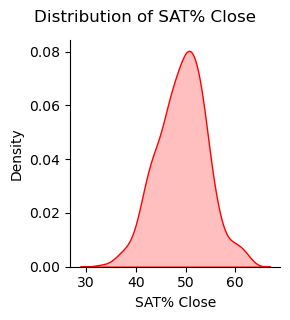

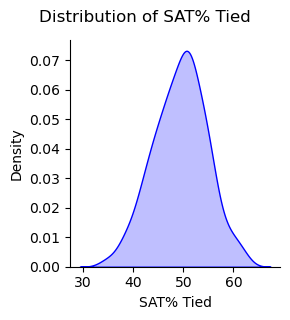

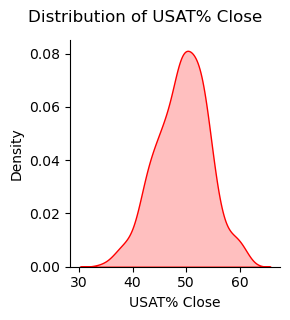

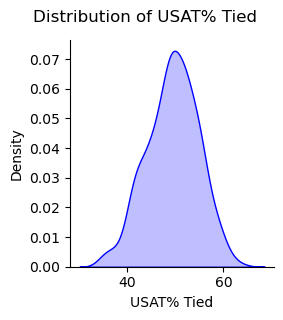

In [17]:
satClose = sns.FacetGrid(df_players_merged).map(sns.kdeplot, 'satPercentageClose', fill=True, color='red')
satClose.fig.suptitle("Distribution of SAT% Close", y = 1.05)
satClose.set_xlabels("SAT% Close")

satTied = sns.FacetGrid(df_players_merged).map(sns.kdeplot, 'satPercentageTied', fill=True, color='blue')
satTied.fig.suptitle("Distribution of SAT% Tied", y = 1.05)
satTied.set_xlabels("SAT% Tied")

usatClose = sns.FacetGrid(df_players_merged).map(sns.kdeplot, 'usatPercentageClose', fill=True, color='red')
usatClose.fig.suptitle("Distribution of USAT% Close", y = 1.05)
usatClose.set_xlabels("USAT% Close")

usatTied = sns.FacetGrid(df_players_merged).map(sns.kdeplot, 'usatPercentageTied', fill=True, color='blue')
usatTied.fig.suptitle("Distribution of USAT% Tied", y = 1.05)
usatTied.set_xlabels("USAT% Tied")

In [18]:
df_players_merged[['gameWinningGoals', 'otGoals', 'shGoals']].describe(percentiles=[0.75, 0.8, 0.9])

,gameWinningGoals,otGoals,shGoals
count,476.000000,476.000000,476.000000
mean,2.302521,0.334034,0.462185
std,2.442793,0.704704,0.873371
min,0.000000,0.000000,0.000000
50%,2.000000,0.000000,0.000000
75%,3.000000,0.000000,1.000000
80%,4.000000,1.000000,1.000000
90%,5.000000,1.000000,2.000000
max,13.000000,4.000000,6.000000


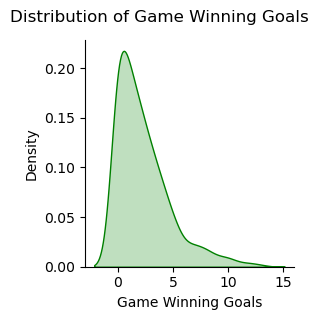

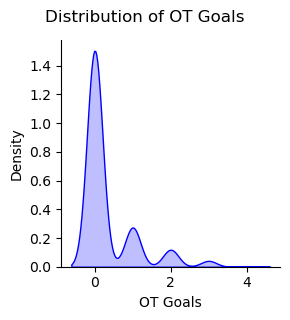

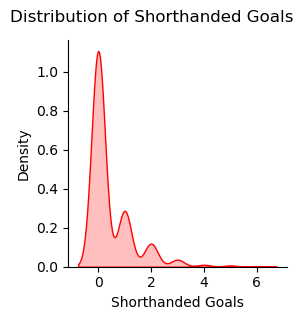

In [19]:
satClose = sns.FacetGrid(df_players_merged).map(sns.kdeplot, 'gameWinningGoals', fill=True, color='green')
satClose.fig.suptitle("Distribution of Game Winning Goals", y = 1.05)
satClose.set_xlabels("Game Winning Goals")

satTied = sns.FacetGrid(df_players_merged).map(sns.kdeplot, 'otGoals', fill=True, color='blue')
satTied.fig.suptitle("Distribution of OT Goals", y = 1.05)
satTied.set_xlabels("OT Goals")

usatClose = sns.FacetGrid(df_players_merged).map(sns.kdeplot, 'shGoals', fill=True, color='red')
usatClose.fig.suptitle("Distribution of Shorthanded Goals", y = 1.05)
usatClose.set_xlabels("Shorthanded Goals")

In [20]:
gameWinningGoalsQuantile = df_players_merged['gameWinningGoals'].quantile(0.8)

def binary_clutchness(row):
    clutchness = (row['satPercentageClose'] >= 55) or (row['satPercentageTied'] >= 55) or (row['usatPercentageClose'] >= 55) or (row['usatPercentageTied'] >= 55) and (row['gameWinningGoals'] >= gameWinningGoalsQuantile)
    if clutchness:
        return 1
    else:
        return 0
        
df_players_merged['clutch_performance'] = df_players_merged.apply(binary_clutchness, axis=1)

In [21]:
df_players_merged['clutch_performance'].value_counts()

clutch_performance
0    394
1     82
Name: count, dtype: int64

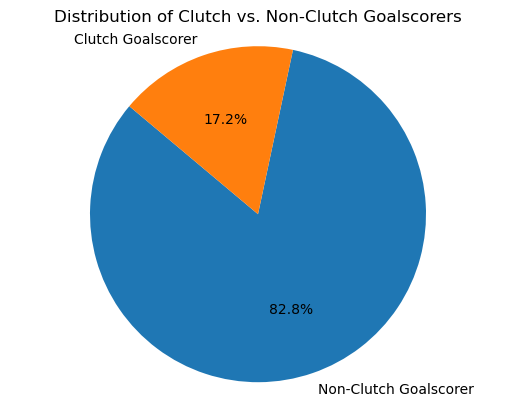

In [22]:
key = ['Non-Clutch Goalscorer', 'Clutch Goalscorer',]

plt.pie(df_players_merged['clutch_performance'].value_counts(), labels=key, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Clutch vs. Non-Clutch Goalscorers')
plt.axis('equal') 
plt.show()

In [96]:
x_var = ['usatPercentageClose', 'usatPercentageTied', 'satPercentageClose', 'satPercentageTied', 'gameWinningGoals']
y_var = ['clutch_performance']
train, test = train_test_split(df_players_merged, test_size = 0.3)

xgb_model = xgb.XGBClassifier(n_estimators=100, eval_metric='mlogloss')
xgb_model.fit(train[x_var], train[y_var])

test['xgb_clutch_type'] = xgb_model.predict(test[x_var])
test['xgb_correct'] = (test['xgb_clutch_type'] == test['clutch_performance'])
xgb_accuracy = test['xgb_correct'].mean()
xgb_accuracy

0.993006993006993

In [97]:
scores = cross_val_score(xgb_model, df_players_merged[x_var], df_players_merged[y_var].values.ravel(), cv=10)
scores

array([1.        , 0.97916667, 0.95833333, 1.        , 0.97916667,
       0.95833333, 0.9787234 , 1.        , 1.        , 0.95744681])

In [98]:
scores.mean()

0.9811170212765958

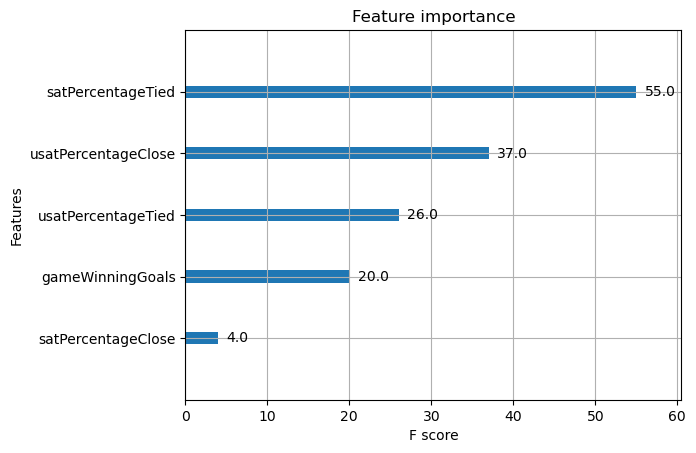

In [99]:
plot_importance(xgb_model, importance_type='weight')
plt.show()

In [100]:
x_var_adjusted = ['usatPercentageClose', 'usatPercentageTied', 'satPercentageTied']
y_var = 'clutch_performance'

scale_pos_weight = (df_players_merged['clutch_performance'] == 0).sum() / (df_players_merged['clutch_performance'] == 1).sum()

param_grid = {
    'max_depth': [1, 3, 5],
    'n_estimators': [100, 200, 300],
    'subsample': [0.65, 0.7, 0.75, 0.8, 0.85],
    'colsample_bytree': [0.65, 0.7, 0.75, 0.8, 0.85],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'scale_pos_weight': [scale_pos_weight],
}

random_search = RandomizedSearchCV(estimator = xgb_model, param_distributions = param_grid, scoring = 'balanced_accuracy', cv = 5, n_jobs = -1, verbose = 1)

random_search.fit(train[x_var_adjusted], train[y_var])

print("Best Parameters:", random_search.best_params_)
print("Best Balanced Accuracy:", random_search.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'subsample': 0.65, 'scale_pos_weight': 4.804878048780488, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 1, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 0.75}
Best Balanced Accuracy: 0.9749943039416724


In [101]:
best_model = random_search.best_estimator_
best_model.fit(train[x_var], train[y_var])

accuracy = best_model.score(test[x_var], test[y_var])
print("Accuracy:", accuracy)

Accuracy: 0.9440559440559441


In [102]:
cv_scores = cross_val_score(best_model, df_players_merged[x_var], df_players_merged[y_var], cv=10)

cv_scores

array([0.9375    , 0.97916667, 0.95833333, 0.97916667, 0.97916667,
       0.97916667, 0.95744681, 1.        , 0.9787234 , 0.95744681])

In [103]:
cv_scores.mean()

0.9706117021276597

In [104]:
y_pred = best_model.predict(test[x_var])  
y_true = test[y_var]

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Precision: 0.8055555555555556
Recall: 0.9666666666666667
F1 Score: 0.8787878787878789


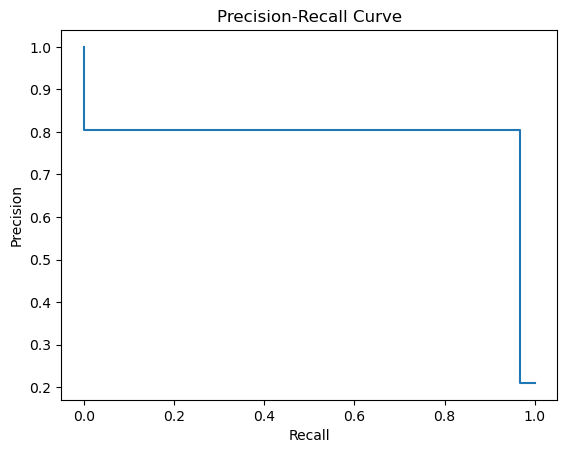

In [105]:
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_true, y_pred)

display = PrecisionRecallDisplay(precision=precision, recall=recall)

display.plot()

plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Precision-Recall Curve")

plt.show()

In [107]:
probability = best_model.predict_proba(test[x_var])[:, 1]

auc_pr = average_precision_score(test[y_var], probability)

auc_pr

0.9817724867724869

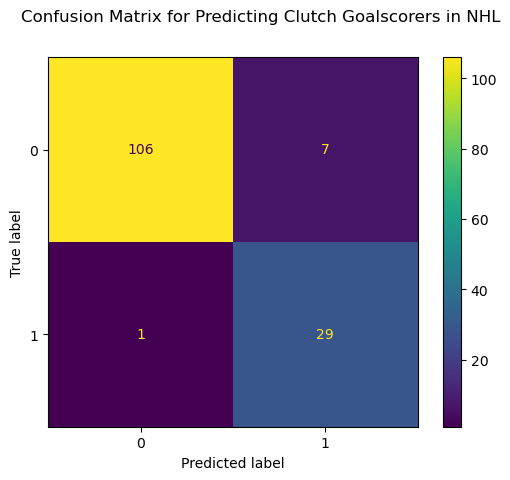

In [108]:
conf_matrix = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

disp.plot()
plt.suptitle('Confusion Matrix for Predicting Clutch Goalscorers in NHL')
plt.show()

In [109]:
accuracy = (conf_matrix[0, 0] + conf_matrix[1, 1]) / np.sum(conf_matrix)
accuracy

0.9440559440559441

In [110]:
df_players_merged['gameWinningGoalsPercentile'] = df_players_merged['gameWinningGoalsPercentile'].astype(str) + '%'
df_players_merged['tiedPercentile'] = df_players_merged['tiedPercentile'].astype(str) + '%'
df_players_merged['closePercentile'] = df_players_merged['closePercentile'].astype(str) + '%'
df_players_merged['final'] = df_players_merged['final'].astype(str) + '%'

In [111]:
df_players_merged.to_csv(r'C:\Users\shakj\Desktop\nhl_clutch_player_data1.csv', index=False)

In [112]:
df_players_merged

,playerId,skaterFullName,lastName,positionCode,teamAbbrevs,gamesPlayed,shootsCatches,satPercentageClose,satPercentageTied,usatPercentageTied,...,satPercentageClosePercentile,satPercentageTiedPercentile,usatPercentageTiedPercentile,usatPercentageClosePercentile,gameWinningGoalsPercentile,tiedPercentile,closePercentile,final,finalRank,clutch_performance
0,8478028,Fredrik Olofsson,Olofsson,L,COL,57,L,46.4,43.6,40.1,...,27.94,15.13,3.99,13.76,36.97%,9.56%,20.85%,23.91%,399.0,0
1,8475763,Kevin Hayes,Hayes,R,STL,79,L,45.0,44.3,43.0,...,20.48,18.28,13.76,13.76,55.67%,16.02%,17.12%,32.21%,355.0,0
2,8471698,T.J. Oshie,Oshie,R,WSH,56,R,43.3,41.6,41.1,...,12.82,8.61,7.25,11.55,80.78%,7.93%,12.18%,38.35%,320.0,0
3,8482259,Bobby McMann,McMann,C,TOR,56,L,52.3,51.8,50.9,...,72.90,67.65,59.56,78.36,13.34%,63.6%,75.63%,47.1%,267.0,0
4,8480748,Kiefer Sherwood,Sherwood,L,NSH,74,R,52.0,53.5,53.4,...,70.38,78.26,76.16,70.80,55.67%,77.21%,70.59%,66.61%,123.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,8474870,Tyler Johnson,Johnson,C,CHI,67,R,37.4,37.3,37.7,...,1.16,1.68,2.31,0.84,36.97%,2.0%,1.0%,15.69%,438.0,0
472,8475913,Mark Stone,Stone,R,VGK,63,R,45.5,43.1,42.1,...,21.85,13.34,10.82,20.80,87.82%,12.08%,21.33%,45.15%,281.0,0
473,8478831,Kevin Stenlund,Stenlund,C,FLA,105,R,48.8,51.1,48.8,...,44.33,61.03,43.70,33.82,70.17%,52.36%,39.08%,55.5%,207.0,0
474,8476483,Rickard Rakell,Rakell,R,PIT,70,R,52.7,52.8,52.5,...,76.05,74.16,71.64,66.49,55.67%,72.9%,71.27%,65.52%,130.0,0


In [113]:
df_players_merged['finalRank'] = df_players_merged['finalRank'].astype(int)

df_players_merged.rename(columns={'skaterFullName': 'Name', 'closePercentile': 'Close Percentile', 'tiedPercentile': 'Tied Percentile', 'closePercentile': 'Close Percentile', 'gameWinningGoalsPercentile': 'GWG Percentile', 'final': 'Clutch Percentile','finalRank': 'Rank'}, inplace=True)

df_players_merged[['Name', 'Close Percentile',  'Tied Percentile', 'Clutch Percentile', 'GWG Percentile', 'Rank']].sort_values('Rank', ascending=True).head(5)

,Name,Close Percentile,Tied Percentile,Clutch Percentile,GWG Percentile,Rank
399,Zach Hyman,97.0%,97.38%,97.73%,98.53%,1
188,Sebastian Aho,96.96%,96.12%,97.63%,99.26%,2
12,Seth Jarvis,96.64%,97.38%,97.2%,97.48%,3
252,Andrei Svechnikov,98.37%,94.02%,96.12%,96.01%,4
194,Sam Reinhart,93.48%,93.49%,96.09%,100.0%,5


In [114]:
df_players_merged[['Name', 'Close Percentile',  'Tied Percentile', 'GWG Percentile', 'Clutch Percentile', 'Rank']].sort_values('Rank', ascending=True).head(10)

,Name,Close Percentile,Tied Percentile,GWG Percentile,Clutch Percentile,Rank
399,Zach Hyman,97.0%,97.38%,98.53%,97.73%,1
188,Sebastian Aho,96.96%,96.12%,99.26%,97.63%,2
12,Seth Jarvis,96.64%,97.38%,97.48%,97.2%,3
252,Andrei Svechnikov,98.37%,94.02%,96.01%,96.12%,4
194,Sam Reinhart,93.48%,93.49%,100.0%,96.09%,5
338,Nathan MacKinnon,95.32%,93.65%,97.48%,95.68%,6
110,Aleksander Barkov,94.54%,94.7%,96.01%,95.18%,7
166,Mikko Rantanen,93.38%,91.23%,98.53%,94.8%,8
87,Connor McDavid,97.84%,95.28%,91.6%,94.58%,9
397,Artemi Panarin,90.44%,90.18%,97.48%,93.18%,10
